# Project scope

This is a self-development project geared towards gaining a practical understanding on how to deploy a CNN for binary classification problems within healthcare using tensorflow. It broadened my understanding on how to pre-process image data suitable for ingestion by a CNN and how to gradually fine tune and build a sequential CNN. Without great lengths, the notebook explains the reasoning behind the chosen steps for: data pre-processing, image augmentation and CNN training. Aside from the technical implementation it enabled me to get the hang on how to develop a solution that can support health care professionals. References to all resources used that helped me further my knowledge on the topic are listed below. 

# Data source

The data used in this project can be found on kaggle and comprises c. 5.8k chest X-ray images (anterior-posterior) of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. You can read more about the data using the following link:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# Approach

Data is organized in 3 separate directories: train, validation, and test. Within each there were separate directories for X-ray images with normal lungs and pneumonia lungs. This folder structure allowed me to take advantage of keras' ImageDataGenerator function for pre-processing the data. ImageDataGenerator requires low memory usage as it is loading the images in batches allowing me to efficiently process the model just using my local machine.<br><br>
Before training the model, I have set a random seed to allow for reproducibility of results and remove the randomness that occurs during training when the training parameters are initialized at random.<br><br> 
This project is more focused on implementation than hyper parameter tunning, thus I opted for using VGG16’s pre-processing specifications as it showed good training performance compared to other set ups. *VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper Very Deep Convolutional Networks for Large-Scale Image Recognition. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.*<br><br>

# Limitations

A main data limitation is the fact that the model is training on images of a specific age band, meaning that there is a high chance of it not generalizing well, for example, using X-ray images of adults.<br><br>
The CNN was also training in a local machine with limited computational power that restricted some training choices such as: batch size, number of epochs and number CNN layers.

# Setup

python                    3.9.7<br>
keras                     2.7.0<br>
keras-preprocessing       1.1.2<br>
scikit-learn              1.0.2<br>
tensorflow                2.7.0<br>
tensorflow-estimator      2.7.0<br>

# References

Below are all the references that helped me understand not only the fundamental concepts in CNNs, but also the reasoning behind my data augmentation and hyper parameters choices:<br><br>
**Visualize train images**:<br>
Plotting sample data: https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia<br>
**Data Augmentation & Pre-processing**:<br>
Augmentation techniques: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/<br>
Image Augmentor: https://github.com/mdbloice/Augmentor<br>
ImageDataGenerator: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html<br>
Rescale: https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation<br>
Shearing: https://mathworld.wolfram.com/Shear.html<br>
Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network<br>
**Model training**:<br>
deeplizard, Deep Learning Fundamentals: https://www.youtube.com/playlist?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU<br>
deeplizard, TensorFlow Python Deep Learning Neutal Network API: https://www.youtube.com/playlist?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU<br>
deeplizard, Setting random seed: https://deeplizard.com/learn/video/HcW0DeWRggs<br>
VGG16: https://neurohive.io/en/popular-networks/vgg16/<br>


# Code

In [1]:
# Import libraries

import os
import numpy as np
from PIL import Image
import glob
import shutil
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

# Running code below to allow reproducability of results 
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '' # forcing the code to run on a CPU
np.random.seed(37) # set the random seed for numpy
random.seed(1254) # set the random seed for Python
tf.random.set_seed(89) # set the random seed for tensorflow

# Listing out directories within my project

print(os.listdir("C:\\Users\\diogo\\Desktop\\GitHub\\CNN Image Classification\\chest_xray"))

['.DS_Store', 'test', 'train', 'val']


In [2]:
# Create a folder path for train, validation and test datasets

train_path = 'C:\\Users\\diogo\\Desktop\\GitHub\\CNN Image Classification\\chest_xray\\train'
valid_path = 'C:\\Users\\diogo\\Desktop\\GitHub\\CNN Image Classification\\chest_xray\\val'
test_path = 'C:\\Users\\diogo\\Desktop\\GitHub\\CNN Image Classification\\chest_xray\\test'

In [3]:
# Create a folder path within the train dataset for Normal and Pneumonia images

train_normal = train_path + '\\NORMAL\\'
train_pneumonia = train_path + '\\PNEUMONIA\\'

Number of files on directory: 1342
Normal lungs image:  IM-0539-0001-0002.jpeg
Pneumonia lungs image: person1406_bacteria_3575.jpeg


Text(0.5, 1.0, 'Pneumonia')

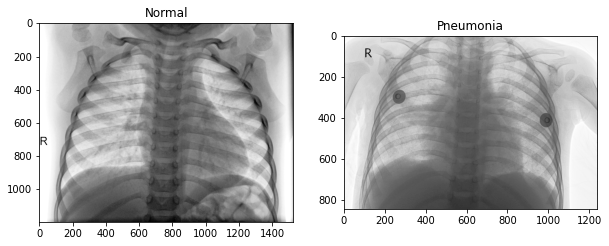

In [4]:
# Visualizing 1 random image in each train folder

# Normal image 

print("Number of files on directory: " + str(len(os.listdir(train_normal)))) # printing number of files in the directory

rand_normal = np.random.randint(0,len(os.listdir(train_normal))) # choosing a random number
normal_pic = os.listdir(train_normal)[rand_normal] # choosing image based on random number
normal_pic_address = train_normal + normal_pic # path to the image
print('Normal lungs image: ',normal_pic) # print

# Pneumonia image

rand_pneumonia = np.random.randint(0,len(os.listdir(train_pneumonia))) # choosing a random number
pneumonia_pic =  os.listdir(train_pneumonia)[rand_pneumonia] # choosing image based on random number
pneumonia_pic_address = train_pneumonia + pneumonia_pic # path to the image
print('Pneumonia lungs image:', pneumonia_pic) # print

# Load the images

normal_load = Image.open(normal_pic_address)
pneumonia_load = Image.open(pneumonia_pic_address)

# Use matplotlib to plot the images

f = plt.figure(figsize= (10,6))

a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load, cmap='Greys') # the default cmap is viridis, changed to grey
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load, cmap='Greys')
a2.set_title('Pneumonia')

In [10]:
# Pre-processing images for training, validation and test datasets 

# Applying the same pre-processing used on vgg16

# Alternative data augmentation parameters that have also showed good performance:

# rescale = 1./255, helps normalizing the data by scaling every images to the same range between [0,1]
# shear_range = 0.2, helps to transform the image by slightly changing its shape relative to a given point 
# zoom_range = 0.2, will randomly zoom inside images
# vertical_flip = False, as X-ray images are not created upside down 

# Image Pre-processing 

# target_size=(224,224), trialled with several and choosing Xp by Xp as it giving better model performance
# batch_size=32, choosing batch size capable of running with my current memory space
# shuffle=False, for test set only as I need to access the right labels at a later stage

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32, \
                         )
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32, \
                         )
test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32, \
                         shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

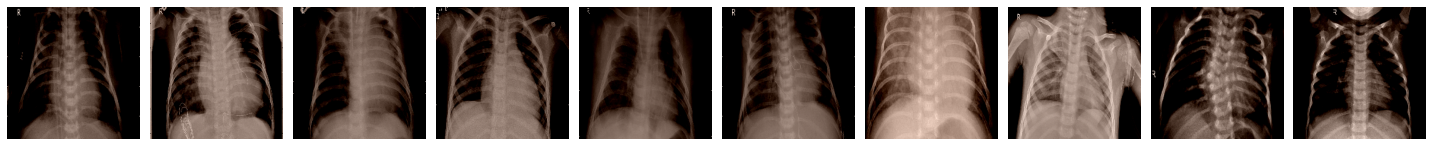

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [11]:
# Grab a sample of images from our train batch for visualization
# It will take the batch size that was specified above

imgs, labels = next(train_batches)

# Taken directly from tensor flow website. Standard code to plot images
# consider using this: cmap='Greys' in imshow() 

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.array(img/np.amax(img)*255, np.int32))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    
# Plot the images
# Limiting the output to only 10 images

plotImages(imgs[:11])
print(labels[:11])

In [12]:
# Code below is useful to understand the shape of the the input

# Color mode: It describes the color format of the images, i.e. GRAY, RGB, or RGBA...
# The color format is represented by channels  1, 3, or 4 and is the last value of the tuple.

# Channel 1 – GRAY format
# Channel 3 – RGB format
# Channel 4 – RGBA format

for img in imgs[:1]:
    print(img.shape)

(224, 224, 3)


In [13]:
# Build the model 

# learning_rate=0.0001
# epochs=10

# First Conv2D layer:
# 32 output filters each with a kernel size of 3x3, and using the relu activation function

# Second Conv2D layer:
# 64 output filters each with a kernel size of 3x3, and using the relu activation function

# Both convolution layers followed by a MaxPool2D layer with poo_size 2x2 and stride of 2

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax') # this is the output layer specifying Pnemonia vs. No-Pnemonia values
])

# Compile the model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Get model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

In [14]:
# Train the model with patiente early stopping

# patient early stopping
# we will allow training to continue for up to an additional 10 epochs

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model over training based on accuracy
mc = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model 

# note: data is specified as a generator, thus no need to specify y (it is contained in the generator itself)

history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches), # became a mandatory parameter
    validation_data=valid_batches,
    validation_steps=len(valid_batches), # became a mandatory parameter
    epochs=100,
    verbose=2, # most verbose output
    callbacks=[es, mc] # for early stopping and saving best model  
)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.87500, saving model to models\best_model.h5
163/163 - 208s - loss: 1.1043 - accuracy: 0.9105 - val_loss: 0.2134 - val_accuracy: 0.8750 - 208s/epoch - 1s/step
Epoch 2/100

Epoch 00002: val_accuracy did not improve from 0.87500
163/163 - 199s - loss: 0.1240 - accuracy: 0.9674 - val_loss: 0.8719 - val_accuracy: 0.6875 - 199s/epoch - 1s/step
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.87500 to 0.93750, saving model to models\best_model.h5
163/163 - 197s - loss: 0.0499 - accuracy: 0.9841 - val_loss: 0.1578 - val_accuracy: 0.9375 - 197s/epoch - 1s/step
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.93750
163/163 - 196s - loss: 0.0450 - accuracy: 0.9845 - val_loss: 1.4362 - val_accuracy: 0.7500 - 196s/epoch - 1s/step
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.93750
163/163 - 190s - loss: 0.0234 - accuracy: 0.9914 - val_loss: 0.9066 - val_accuracy: 0.8125 - 190s/epoch - 1s/step
Epoch 6/1

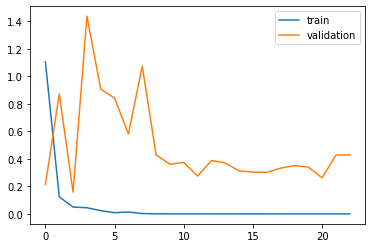

In [17]:
# Plot training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [16]:
# Save the model 

history.save('models/best_model.h5')

In [18]:
# Load the model

pneumonia_detection = load_model('models/best_model.h5')

In [19]:
# Make predictions

predictions = pneumonia_detection.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [20]:
# Verify the class mapping for confusion matrix

test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[128 106]
 [ 47 343]]


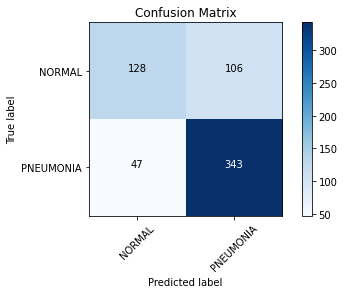

In [21]:
# Create confusion matrix

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ['NORMAL','PNEUMONIA'] # Define mapping

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') # Plot the matrix